In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import string
from tqdm import tqdm_notebook as tqdm

from gensim.models import *

from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import *
from keras.models import *
import keras.backend as K
from keras.utils import np_utils

from keras.callbacks import *

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from keras import regularizers
from numpy import array
from numpy import asarray
from numpy import zeros

In [5]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [7]:
pip install simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.7/250.7 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 53.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 32.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 4.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 87.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 100.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 21.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 2

In [8]:
from simpletransformers.classification import ClassificationModel
import pandas as pd

In [9]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=25)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=15)
    plt.yticks(tick_marks, classes, fontsize=15)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize = 14)

    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

In [15]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/tamil_sentiment_full.csv',sep='\t',names=['category','text'])
y=df['category'].tolist()
X_train, X_test, y_train, y_test = train_test_split(df['text'].tolist(), y, random_state=5, test_size=0.2) #train, test split
#validation split
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(y_train),
                                                 y = y_train)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=5, test_size=0.1)

In [13]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
list_of_class={'not-Tamil':0,'Positive':1,'Negative':2,'unknown_state':3,'Mixed_feelings':4}
y_val=[list_of_class[i.strip()]for i in y_val]
y_train=[list_of_class[i.strip()]for i in y_train]
y_test=[list_of_class[i.strip()]for i in y_test]

In [18]:
class_weights

array([1.49575263e+00, 1.41429719e+00, 2.94748824e-01, 5.86933333e+03,
       3.52089582e+00, 1.05544566e+00])

In [19]:
# class_weights=[3.23783784, 1.797     , 0.48005343, 1.52503536, 0.71641196]
# class_weights

In [20]:
# Train and Evaluation data needs to be in a Pandas Dataframe containing at least two columns. If the Dataframe has a header, it should contain a 'text' and a 'labels' column. If no header is present, the Dataframe should contain at least two columns, with the first column is the text with type str, and the second column in the label with type int.
train_data = [['Example sentence belonging to class 1', 1], ['Example sentence belonging to class 0', 0], ['Example eval senntence belonging to class 2', 2]]
train_df = pd.DataFrame(train_data)

In [21]:
train_df

,0,1
0,Example sentence belonging to class 1,1
1,Example sentence belonging to class 0,0
2,Example eval senntence belonging to class 2,2


In [22]:
X_train

['Yuvan Anna fans hit like  here',
 'Thoothukudi dist yadav sarbaga win panna vazhthukkal',
 'hii.vijay sir .spr semma mass.so handsome u look. pattaiya kelaparinga.',
 'Hip hop fans hit like here',
 'எந்த சமூகமாக இருந்தாலும் உங்களுக்கான சிறந்த தலைவரை தேர்ந்தெடுங்கள்.தவறான தலைவர் உங்கள் சமூகத்தை தவறாக வழி நடத்திச் செல்வார். உன் உழைப்பால் உயர்ந்து வாழ்ந்து காட்டு என்று கூறுபவன் சிறந்த தலைவன் .அடுத்தவன் உழைத்ததை தன் உழைப்பால் என்றும் பிடுங்க முடியாது.தீரன் சின்னமலை பேரவையின் வாயிலாக தயாரிப்பாளருக்கும் இயக்குனருக்கும் வாழ்த்துக்களைத் தெரிவித்துக் கொள்கிறேன்',
 'u will c my rage........Vakkaali Thala rokzzzzzzzzzzzzzzzzzzzzzzzzzzzzz........',
 'super thalva  super star Rajni',
 'Vera level ma sema different aa irukh',
 'Rajini scene cut pannathukku, ethiruppu iruntha like pottu unga aatharava therivinga makkalae...',
 'Dhum biryani ready for #suriya fans',
 'vijai fans + Thalaivar Fans Meet pannalama Ready start 1 2 3',
 'Dei director the***** 96 la varen Thalaivar sollaveillada yepdi ipdi

In [23]:
df_train=pd.DataFrame(X_train,y_train)

In [24]:
df_valid=pd.DataFrame(X_val,y_val)
df_test=pd.DataFrame(X_test,y_test)

In [25]:
df_train

,0
1,Yuvan Anna fans hit like here
1,Thoothukudi dist yadav sarbaga win panna vazht...
1,hii.vijay sir .spr semma mass.so handsome u lo...
3,Hip hop fans hit like here
1,எந்த சமூகமாக இருந்தாலும் உங்களுக்கான சிறந்த தல...
...,...
3,"விஜய் அஜித் உட்பட நான்கு இளைஞர்கள் கைது, கற்பழ..."
1,Nadipin nayagan suriya marana mass
2,Intha comment section la type pannuna anaivaru...
1,Nan 75 views ah cross panniten....anyone else ...


In [26]:
df_train.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/tamil_sentiment_full_train.csv',sep='\t',header=False)
df_valid.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/tamil_sentiment_full_dev.csv',sep='\t',header=False)
df_test.to_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/tamil_sentiment_full_test.csv',sep='\t',header=False)

In [28]:
df_train=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/tamil_sentiment_full_train.csv',sep='\t',names=['category','text'])
df_test=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/tamil_sentiment_full_test.csv',sep='\t',names=['category','text'])
df_valid=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP END SEM/tamil_sentiment_full_dev.csv',sep='\t',names=['category','text'])

In [ ]:
#df_valid=pd.read_csv('Malayalam_Code_Mix_val.csv',sep='\t',names=['f','m'])
df_valid=df_valid[['text','category']]
df_train=df_train[['text','category']]
df_test=df_test[['text','category']]
#df_valid

In [30]:
model = ClassificationModel('bert', 'bert-base-multilingual-cased', num_labels=5, args={'reprocess_input_data': True, 'overwrite_output_dir': True}, use_cuda=False) 
# You can set class weights by using the optional weight argument

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

In [31]:
model.train_model(df_train)

/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:612: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/31694 [00:00<?, ?it/s]

ValueError: ignored

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_valid)

/home/bharaj/anaconda3/lib/python3.6/site-packages/simpletransformers/classification/classification_model.py:568: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Features loaded from cache at cache_dir/cached_dev_bert_128_5_1260


A Jupyter Widget


{'mcc': 0.2191250717811231, 'eval_loss': 0.893118800241736}


In [ ]:
predictions, raw_outputs = model.predict(df_test['text'])

Features loaded from cache at cache_dir/cached_dev_bert_128_5_3149


A Jupyter Widget

In [ ]:
predictions


array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
list_of_class_v={0:'not-Tamil',1:'Positive',2:'Negative',3:'unknown state',4:'Mixed feelings'}

In [ ]:
print(classification_report([list_of_class_v[i] for i in y_test], 
                            [list_of_class_v[i] for i in predictions]))

                precision    recall  f1-score   support

Mixed feelings       0.00      0.00      0.00       377
      Negative       0.42      0.03      0.05       424
      Positive       0.68      0.99      0.80      2075
     not-Tamil       0.60      0.65      0.62       100
 unknown state       0.00      0.00      0.00       173

     micro avg       0.67      0.67      0.67      3149
     macro avg       0.34      0.33      0.29      3149
  weighted avg       0.52      0.67      0.56      3149



/home/bharaj/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


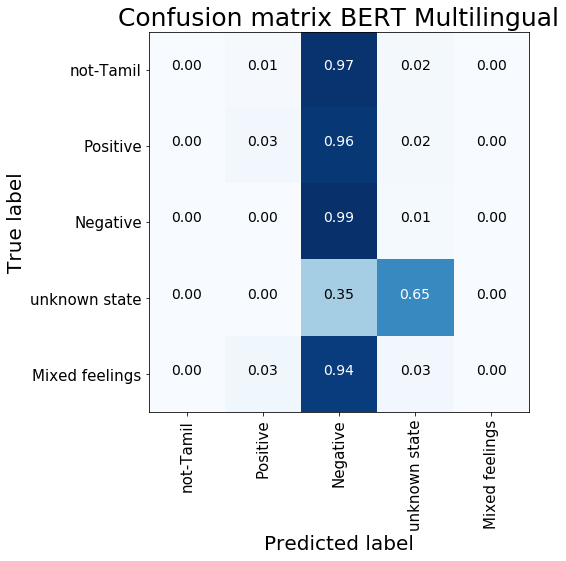

In [ ]:
cnf_matrix = confusion_matrix([list_of_class_v[i] for i in y_test], 
                              [list_of_class_v[i] for i in predictions])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(list_of_class_v.values()), title="Confusion matrix BERT Multilingual")
plt.show()

# BERT

In [ ]:
model = ClassificationModel('bert', 'bert-base-cased', num_labels=5, args={'reprocess_input_data': True, 'overwrite_output_dir': True}) 
# You can set class weights by using the optional weight argument


I0211 10:35:14.519652 139752635905792 configuration_utils.py:185] loading configuration file https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json from cache at /home/bharaj/.cache/torch/transformers/b945b69218e98b3e2c95acf911789741307dec43c698d35fad11c1ae28bda352.3d5adf10d3445c36ce131f4c6416aa62e9b58e1af56b97664773f4858a46286e
I0211 10:35:14.521729 139752635905792 configuration_utils.py:199] Model config {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "output_attentions": false,
  "output_

In [ ]:
model.train_model(df_train)


Converting to features started. Cache is not used.


/home/bharaj/anaconda3/lib/python3.6/site-packages/simpletransformers/classification/classification_model.py:237: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


A Jupyter Widget


Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


A Jupyter Widget

A Jupyter Widget

Running loss: 1.214257Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Running loss: 1.045378

I0211 10:44:49.184058 139752635905792 configuration_utils.py:87] Configuration saved in outputs/checkpoint-1417-epoch-1/config.json


I0211 10:44:53.072467 139752635905792 modeling_utils.py:258] Model weights saved in outputs/checkpoint-1417-epoch-1/pytorch_model.bin
I0211 10:44:53.331390 139752635905792 configuration_utils.py:87] Configuration saved in outputs/config.json


I0211 10:44:57.238466 139752635905792 modeling_utils.py:258] Model weights saved in outputs/pytorch_model.bin


Training of bert model complete. Saved to outputs/.


In [ ]:
#model.save('BERT_BASE_TAMIL.h5') 

In [ ]:
result, model_outputs, wrong_predictions = model.eval_model(df_valid)


/home/bharaj/anaconda3/lib/python3.6/site-packages/simpletransformers/classification/classification_model.py:568: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."


Features loaded from cache at cache_dir/cached_dev_bert_128_5_1260


A Jupyter Widget

RuntimeError: cublas runtime error : the GPU program failed to execute at /opt/conda/conda-bld/pytorch_1556653183467/work/aten/src/THC/THCBlas.cu:315

In [ ]:
predictions, raw_outputs = model.predict(df_test['text'])
print(classification_report([list_of_class_v[i] for i in y_test], 
                            [list_of_class_v[i] for i in predictions]))
cnf_matrix = confusion_matrix([list_of_class_v[i] for i in y_test], 
                              [list_of_class_v[i] for i in predictions])

plt.figure(figsize=(7,7))
plot_confusion_matrix(cnf_matrix, classes=list(diz_label.values()), title="Confusion matrix BERT")
plt.show()